In [2]:
%load_ext autoreload
%autoreload 2
import sys 
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
%config Completer.use_jedi = False

In [3]:
(Path.cwd().parent)

PosixPath('/home/ubuntu/varios/skforecast')

In [4]:
import matplotlib.pyplot as plt
import joypy
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg

from scipy import stats

In [5]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')
data.info()

# Data preprocessing
# ==============================================================================
data = data.copy()
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='D', closed='left', label ='right').mean()

# Data alteration
# ==============================================================================
rng = np.random.default_rng(seed=123)
data.loc["2012-06": "2012-09", "Demand"] = rng.normal(
                                              loc   = 3000,
                                              scale = 100,
                                              size  = len(data.loc["2012-06": "2012-09"])
                                          )

# Split data into train-val-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_validation = '2014-10-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB
Dates train      : 2012-01-01 00:00:00 --- 2013-12-31 00:00:00  (n=731)
Dates validacion : 2014-01-01 00:00:00 --- 2014-10-31 00:00:00  (n=304)
Dates test       : 2014-11-01 00:00:00 --- 2014-12-30 00:00:00  (n=60)


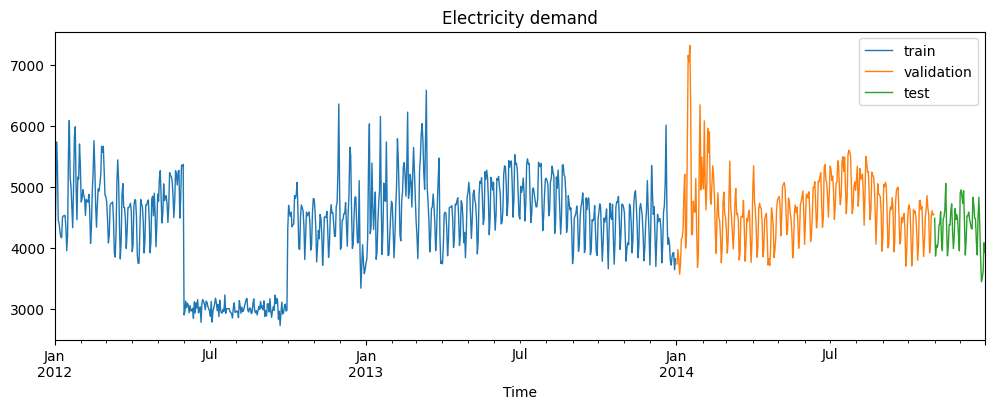

In [6]:
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
data_train.Demand.plot(ax=ax, label='train', linewidth=1)
data_val.Demand.plot(ax=ax, label='validation', linewidth=1)
data_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity demand')
ax.legend();

In [7]:
# Create Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor    = HistGradientBoostingRegressor(random_state=123),
                 lags         = 21,
                 transformer_y=StandardScaler()
             )
forecaster.fit(y=data.Demand)


In [8]:
predictions = forecaster.predict(steps=3)
predictions

2014-12-31    3940.691200
2015-01-01    3902.964987
2015-01-02    3899.472244
Freq: D, Name: pred, dtype: float64

In [9]:
boot_samples = forecaster.predict_bootstrapping(steps=20,  n_boot=100)
boot_samples


,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9,...,pred_boot_90,pred_boot_91,pred_boot_92,pred_boot_93,pred_boot_94,pred_boot_95,pred_boot_96,pred_boot_97,pred_boot_98,pred_boot_99
2014-12-31,3944.811565,3931.016868,3954.389990,3985.820688,3959.957663,4317.593229,3913.526991,3839.112068,3906.929497,3962.123340,...,3988.641793,3956.401791,3965.605301,3937.303242,4007.011233,4036.858429,3904.843847,3969.109417,4013.861989,3924.087587
2015-01-01,3818.836150,3850.407501,3910.194081,4013.827934,3781.016701,4112.865997,3838.587189,3784.074649,3804.838353,3928.326220,...,3915.750434,3430.801918,3879.287038,3814.611558,3933.837644,4053.879059,3783.011664,3924.397127,4130.201563,3824.637409
2015-01-02,3730.847956,3783.376964,3863.374228,3945.971324,3779.094904,4036.338813,3617.387778,3786.336846,3705.924851,3818.278871,...,4437.287854,3499.679488,3764.197566,3844.780830,3854.991172,4121.011595,3617.542813,3914.428343,4093.861486,3724.379767
2015-01-03,3913.275556,3881.623053,4056.958564,4533.365701,3861.198090,4290.590463,3812.018797,3826.568125,3833.453680,3947.795230,...,4280.922792,3531.926780,3883.347209,3894.769079,4059.360684,4213.364065,3882.450830,4141.767172,4355.296283,3839.934382
2015-01-04,4276.933821,4138.467704,4138.882702,4407.636098,4096.261303,4280.874261,4073.652465,4002.348300,3980.481438,4194.440044,...,4116.062423,3477.175349,4136.643872,4234.371797,4301.717841,4466.018207,4079.231287,4306.773022,4375.176387,3961.492586
2015-01-05,4643.802650,4705.267496,4579.188375,4456.252506,4716.244793,4677.187341,4610.230015,4579.809621,4478.221853,4781.875538,...,4597.714991,3605.959887,4638.781363,4658.560037,4880.669630,4649.360044,4530.242800,4740.221265,4745.692027,4441.592887
2015-01-06,4680.269465,4751.923075,4607.636352,4581.785884,4756.954782,4724.612354,4727.256903,4704.662124,4689.913825,4929.922544,...,4583.228079,3859.316499,4660.886244,4610.890822,5099.512623,4648.543425,4699.802345,4764.471334,5216.934938,4671.921131
2015-01-07,4495.902965,4710.446882,4437.596570,4406.877233,4701.116659,4564.230217,4524.441193,4478.216154,4504.334135,4854.891151,...,4195.963060,4052.634696,4465.203084,4393.351971,4716.723094,4507.142058,4499.153409,4688.167201,4780.295345,4393.645796
2015-01-08,4495.009987,4668.935563,4545.478079,4649.645909,4743.700035,4632.658442,4531.499742,4409.954763,4451.267299,4972.895206,...,4337.621354,4425.764638,4525.612874,4367.509416,4670.691466,4683.278225,4455.920796,4623.357981,4588.298909,4533.813205
2015-01-09,4169.367570,4299.754696,4194.959187,4232.653570,4481.834694,4064.967763,4238.196163,4336.669161,4119.159192,5018.024095,...,4638.697822,4166.942920,4286.649535,4271.335867,4422.399427,4407.227592,4222.996360,4312.360148,4342.176148,4251.931908


In [10]:
predictions = forecaster.predict_interval(steps=3,  n_boot=5)
predictions

,pred,lower_bound,upper_bound
2014-12-31,3940.691200,3933.775807,3980.648083
2015-01-01,3902.964987,3788.580591,3993.101163
2015-01-02,3899.472244,3740.497346,3929.451905


In [11]:
from scipy.stats import norm

predictions = forecaster.predict_dist(steps=3,  n_boot=5, distribution=norm)
predictions

,loc,scale
2014-12-31,3955.199355,18.186047
2015-01-01,3874.856473,81.367985
2015-01-02,3820.533075,75.777619


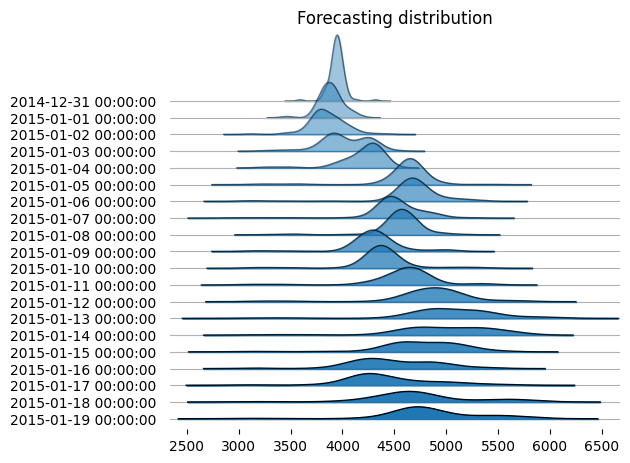

In [12]:
fig, axes = joypy.joyplot(boot_samples.transpose(),range_style='own', grid="y",linewidth=1, legend=False, fade=True,
                          hist=False, title="Forecasting distribution")

In [13]:
forecaster.predict_dist(steps=3, distribution=stats.norm, n_boot=4)

,loc,scale
2014-12-31,3954.009778,20.157875
2015-01-01,3898.316416,74.324233
2015-01-02,3830.892618,81.493612


In [31]:
from sklearn.linear_model import LinearRegression
from skforecast.utils import transform_series

In [95]:
y = pd.Series(np.arange(10), name='y', index=pd.RangeIndex(10))
exog_train=pd.Series(np.arange(10), name='exog', index=pd.RangeIndex(10))
exog_pred=pd.Series(np.arange(2), name='exog',  index=pd.RangeIndex(10, 12))


y = pd.Series(np.random.normal(loc=10, scale=3, size=10), name='y', index=pd.RangeIndex(10))
exog_train=pd.Series(np.random.normal(loc=10, scale=3, size=10), name='exog', index=pd.RangeIndex(10))
exog_pred=pd.Series(np.random.normal(loc=10, scale=3, size=2), name='exog',  index=pd.RangeIndex(10, 12))

In [103]:
y

0    12.830699
1     9.938612
2    13.221755
3     8.935636
4    13.054966
5    14.054295
6     9.881721
7     0.944736
8    16.491581
9    11.656987
Name: y, dtype: float64

In [97]:
print("NO SCALING")
print("==========")

forecaster = ForecasterAutoreg(
                LinearRegression(),
                lags=3,
                #transformer_y = StandardScaler()
            )

forecaster.fit(y=y)
print(forecaster.predict(2))
print("")
print(forecaster.in_sample_residuals)
print("")
print(forecaster.predict_bootstrapping(2, n_boot=4))
print("")
print(forecaster.predict_interval(2, n_boot=4))
print("")

print("SCALING")
print("==========")
forecaster = ForecasterAutoreg(
                LinearRegression(),
                lags=3,
                transformer_y = StandardScaler()
            )

forecaster.fit(y=y)
print(forecaster.predict(2))
print("")
print(forecaster.in_sample_residuals)
print("")
print(forecaster.predict_bootstrapping(2, n_boot=4))
print(forecaster.predict_interval(2, n_boot=4))
print("")

NO SCALING
10    14.668157
11     3.062204
Name: pred, dtype: float64

3    0.709483
4    1.628932
5    5.359415
6    1.143409
7   -6.708379
8    0.547274
9   -2.680133
Name: in_sample_residuals, dtype: float64

    pred_boot_0  pred_boot_1  pred_boot_2  pred_boot_3
10    20.027572    20.027572    15.811566    15.377640
11    -7.435500    -0.179846     3.882699     3.703979

         pred  lower_bound  upper_bound
10  14.668157    15.442729    20.027572
11   3.062204    -6.347151     3.855891

SCALING
10    14.668157
11     3.062204
Name: pred, dtype: float64

3    0.177330
4    0.407140
5    1.339547
6    0.285787
7   -1.676712
8    0.136787
9   -0.669880
Name: in_sample_residuals, dtype: float64

    pred_boot_0  pred_boot_1  pred_boot_2  pred_boot_3
10    20.027572    20.027572    15.811566    15.377640
11    -7.435500    -0.179846     3.882699     3.703979
         pred  lower_bound  upper_bound
10  14.668157    15.442729    20.027572
11   3.062204    -6.347151     3.855891



In [99]:
print("NO SCALING")
print("==========")

forecaster = ForecasterAutoreg(
                LinearRegression(),
                lags=3,
                #transformer_y = StandardScaler(),
                #transformer_exog = StandardScaler(),
            )

forecaster.fit(y=y, exog=exog_train)
print(forecaster.predict(2, exog=exog_pred))
print("")
print(forecaster.in_sample_residuals)
print("")
print(forecaster.predict_bootstrapping(2, exog=exog_pred, n_boot=4))
print("")
print(forecaster.predict_interval(2, exog=exog_pred, n_boot=4))
print("")

print("SCALING")
print("==========")
forecaster = ForecasterAutoreg(
                LinearRegression(),
                lags=3,
                transformer_y = StandardScaler(),
                transformer_exog = StandardScaler(),
            )

forecaster.fit(y=y, exog=exog_train)
print(forecaster.predict(2, exog=exog_pred))
print("")
print(forecaster.in_sample_residuals)
print("")
print(forecaster.predict_bootstrapping(2, exog=exog_pred, n_boot=4))
print("")
print(forecaster.predict_interval(2, exog=exog_pred, n_boot=4))
print("")

NO SCALING
10    16.242224
11     0.626704
Name: pred, dtype: float64

3   -1.930286
4    1.433628
5    6.261776
6    0.937217
7   -4.870612
8    0.248910
9   -2.080634
Name: in_sample_residuals, dtype: float64

    pred_boot_0  pred_boot_1  pred_boot_2  pred_boot_3
10    22.504000    22.504000    17.179441    14.311938
11    -9.020246    -3.900723     1.345444     3.036299

         pred  lower_bound  upper_bound
10  16.242224    14.742063    22.504000
11   0.626704    -8.252317     2.782671

SCALING
10    16.242224
11     0.626704
Name: pred, dtype: float64

3   -0.482461
4    0.358325
5    1.565086
6    0.234251
7   -1.217375
8    0.062213
9   -0.520040
Name: in_sample_residuals, dtype: float64

    pred_boot_0  pred_boot_1  pred_boot_2  pred_boot_3
10    22.504000    22.504000    17.179441    14.311938
11    -9.020246    -3.900723     1.345444     3.036299

         pred  lower_bound  upper_bound
10  16.242224    14.742063    22.504000
11   0.626704    -8.252317     2.782671



In [128]:
print("NO SCALING")
print("==========")

forecaster = ForecasterAutoreg(
                LinearRegression(),
                lags=3,
                #transformer_y = StandardScaler(),
            )

forecaster.fit(y=y)
forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=1.50)
print(forecaster.predict(2))
print("")
print(forecaster.in_sample_residuals)
print("")
print(forecaster.predict_bootstrapping(2, n_boot=4))
print("")

print("SCALING")
print("==========")
forecaster = ForecasterAutoreg(
                LinearRegression(),
                lags=3,
                transformer_y = StandardScaler(),
            )

forecaster.fit(y=y)
forecaster.in_sample_residuals = forecaster.transformer_y.transform(np.full_like(forecaster.in_sample_residuals, fill_value=1.5).reshape(-1, 1))
print(forecaster.predict(2))
print("")
print(forecaster.in_sample_residuals)
print("")
print(forecaster.predict_bootstrapping(2, n_boot=4))
print("")

NO SCALING
50    0.568425
51    0.508733
Name: pred, dtype: float64

[1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5
 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5
 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]

    pred_boot_0  pred_boot_1  pred_boot_2  pred_boot_3
50     2.068425     2.068425     2.068425     2.068425
51     2.267787     2.267787     2.267787     2.267787

SCALING
50    0.568425
51    0.508733
Name: pred, dtype: float64

[[4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [4.29355008]
 [

/home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [104]:
print("NO SCALING")
print("==========")

forecaster = ForecasterAutoreg(
                LinearRegression(),
                lags=3,
                #transformer_y = StandardScaler(),
                #transformer_exog = StandardScaler(),
            )

forecaster.fit(y=y, exog=exog_train)
forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=1.50)
print(forecaster.predict(2, exog=exog_pred))
print("")
print(forecaster.in_sample_residuals)
print("")
print(forecaster.predict_bootstrapping(2, exog=exog_pred, n_boot=4))
print("")

print("SCALING")
print("==========")
forecaster = ForecasterAutoreg(
                LinearRegression(),
                lags=3,
                transformer_y = StandardScaler(),
                transformer_exog = StandardScaler(),
            )

forecaster.fit(y=y, exog=exog_train)
forecaster.in_sample_residuals = forecaster.transformer_y.transform(np.full_like(forecaster.in_sample_residuals, fill_value=1.5).reshape(-1, 1))
print(forecaster.predict(2, exog=exog_pred))
print("")
print(forecaster.in_sample_residuals)
print("")
print(forecaster.predict_bootstrapping(2, exog=exog_pred, n_boot=4))
print("")

NO SCALING
10    16.242224
11     0.626704
Name: pred, dtype: float64

[1.5 1.5 1.5 1.5 1.5 1.5 1.5]

    pred_boot_0  pred_boot_1  pred_boot_2  pred_boot_3
10    17.742224    17.742224    17.742224    17.742224
11     0.982539     0.982539     0.982539     0.982539

SCALING
10    16.242224
11     0.626704
Name: pred, dtype: float64

[[-2.39972611]
 [-2.39972611]
 [-2.39972611]
 [-2.39972611]
 [-2.39972611]
 [-2.39972611]
 [-2.39972611]]

    pred_boot_0  pred_boot_1  pred_boot_2  pred_boot_3
10     6.641125     6.641125     6.641125     6.641125
11    -1.650900    -1.650900    -1.650900    -1.650900



/home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [102]:
print("NO SCALING")
print("==========")

forecaster = ForecasterAutoreg(
                LinearRegression(),
                lags=3,
                #transformer_y = StandardScaler(),
                #transformer_exog = StandardScaler(),
            )

forecaster.fit(y=y, exog=exog_train)
forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=forecaster.in_sample_residuals.values[0])
print(forecaster.predict(2, exog=exog_pred))
print("")
print(forecaster.in_sample_residuals)
print("")
print(forecaster.predict_bootstrapping(2, exog=exog_pred, n_boot=4))
print("")

print("SCALING")
print("==========")
forecaster = ForecasterAutoreg(
                LinearRegression(),
                lags=3,
                transformer_y = StandardScaler(),
                transformer_exog = StandardScaler(),
            )

forecaster.fit(y=y, exog=exog_train)
forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=forecaster.in_sample_residuals.values[0])
print(forecaster.predict(2, exog=exog_pred))
print("")
print(forecaster.in_sample_residuals)
print("")
print(forecaster.predict_bootstrapping(2, exog=exog_pred, n_boot=4))
print("")

NO SCALING
10    16.242224
11     0.626704
Name: pred, dtype: float64

[-1.93028601 -1.93028601 -1.93028601 -1.93028601 -1.93028601 -1.93028601
 -1.93028601]

    pred_boot_0  pred_boot_1  pred_boot_2  pred_boot_3
10    14.311938    14.311938    14.311938    14.311938
11     0.168795     0.168795     0.168795     0.168795

SCALING
10    16.242224
11     0.626704
Name: pred, dtype: float64

[-0.4824612 -0.4824612 -0.4824612 -0.4824612 -0.4824612 -0.4824612
 -0.4824612]

    pred_boot_0  pred_boot_1  pred_boot_2  pred_boot_3
10    14.311938    14.311938    14.311938    14.311938
11     0.168795     0.168795     0.168795     0.168795



In [109]:
transformer = StandardScaler()
y_transformed = pd.Series(transformer.fit_transform(y.to_frame()).flatten(), index = y.index)


0    12.830699
1     9.938612
2    13.221755
3     8.935636
4    13.054966
5    14.054295
6     9.881721
7     0.944736
8    16.491581
9    11.656987
Name: y, dtype: float64

In [116]:
forecaster = ForecasterAutoreg(
                LinearRegression(),
                lags=3,
                #transformer_y = StandardScaler()
            )

forecaster.fit(y=y)
forecaster.in_sample_residuals

3    0.709483
4    1.628932
5    5.359415
6    1.143409
7   -6.708379
8    0.547274
9   -2.680133
Name: in_sample_residuals, dtype: float64

In [118]:
forecaster = ForecasterAutoreg(
                LinearRegression(),
                lags=3,
                #transformer_y = StandardScaler()
            )

forecaster.fit(y=y_transformed)
transformer.transform(forecaster.in_sample_residuals.to_frame())

/home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- in_sample_residuals
Feature names seen at fit time, yet now missing:
- y

  warnings.warn(message, FutureWarning)


array([[-2.73031799],
       [-2.6728787 ],
       [-2.43983009],
       [-2.70321002],
       [-3.19372247],
       [-2.74045139],
       [-2.94207213]])